# Qwen2.5-Omni：视频信息提取的多模态应用探索

我们体验一下如何利用Qwen2.5-Omni从视频流中获取信息。

# 环境准备

如果前面已经安装准备完成，跳过此章节

## 安装相关依赖
安装transformers、qwen-omni-utils、flash-attn --no-build-isolation

```bash
pip uninstall transformers
pip install git+https://github.com/huggingface/transformers@f742a644ca32e65758c3adb36225aef1731bd2a8
pip install accelerate
pip install triton
pip install qwen-omni-utils
pip install -U flash-attn --no-build-isolation
# 用于从魔塔模型库下载模型
pip install modelscope
```



## 模型下载准备

需要提前将模型下载到本地备用
使用 modelscope 中的 snapshot_download 函数下载模型（提前安装modelscope）。
第一个参数为模型名称，第二个参数 cache_dir 用于指定模型的下载路径.
```python

from modelscope import snapshot_download
model_dir = snapshot_download('Qwen/Qwen2.5-Omni-7B', cache_dir='/root/autodl-tmp', revision='master')

```

# 加载模型&导入依赖

加载本地下载的模型，同时启用flash_attention_2加速

In [1]:
import torch
from transformers import Qwen2_5OmniModel, Qwen2_5OmniProcessor
from IPython.display import Video

model_path = "/root/autodl-tmp/Qwen/Qwen2.5-Omni-7B"
model = Qwen2_5OmniModel.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    attn_implementation="flash_attention_2",
)
processor = Qwen2_5OmniProcessor.from_pretrained(model_path)

You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour
Qwen2_5OmniToken2WavModel must inference with fp32, but flash_attention_2 only supports fp16 and bf16, attention implementation of Qwen2_5OmniToken2WavModel will fallback to sdpa.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

# 定义推理函数

推理函数，用于处理视频输入和文本提示，并生成文本输出。

In [3]:
from qwen_omni_utils import process_mm_info  # 导入用于处理多模态信息的工具函数

# @title inference function
def inference(video_path, prompt, sys_prompt):
    """
    推理函数，用于处理视频输入和文本提示，并生成文本输出。

    参数：
    - video_path: 视频文件路径
    - prompt: 用户提供的文本提示
    - sys_prompt: 系统提示，用于定义模型的角色和行为

    返回值：
    - text: 模型生成的文本输出
    """
    # 构建输入消息，包括系统消息和用户消息
    messages = [
        {"role": "system", "content": sys_prompt},  # 系统消息，定义模型的角色和行为
        {"role": "user", "content": [  # 用户消息，包含文本提示和视频输入
                {"type": "text", "text": prompt},  # 文本提示
                {"type": "video", "video": video_path},  # 视频输入路径
            ]
        },
    ]

    # 使用 processor 应用聊天模板，将消息转换为模型可处理的文本格式
    # 参数 tokenize=False 表示不对文本进行分词处理，add_generation_prompt=True 表示添加生成提示
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    # 调用 process_mm_info 函数处理多模态信息
    # 提取音频、图像和视频信息，use_audio_in_video=False 表示不从视频中提取音频信息
    audios, images, videos = process_mm_info(messages, use_audio_in_video=False)

    # 使用 processor 将文本、音频、图像和视频信息转换为模型输入张量
    # return_tensors="pt" 表示返回 PyTorch 张量，padding=True 表示对输入进行填充以匹配最大长度
    inputs = processor(text=text, audios=audios, images=images, videos=videos, return_tensors="pt", padding=True, use_audio_in_video=False)

    # 将输入张量移动到模型所在的设备和数据类型
    inputs = inputs.to(model.device).to(model.dtype)

    # 调用模型的 generate 方法生成输出
    # use_audio_in_video=False 表示在生成过程中不使用音频信息，return_audio=False 表示不返回音频输出
    output = model.generate(**inputs, use_audio_in_video=False, return_audio=False)

    # 解码生成的文本输出
    # skip_special_tokens=True 表示跳过特殊标记，clean_up_tokenization_spaces=False 表示不清理多余的空格
    text = processor.batch_decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=False)

    # 返回生成的文本结果
    return text

# 基于视频提问（一）

In [4]:
#video_path = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen2.5-Omni/shopping.mp4"
video_path = "files/shopping.mp4"

prompt = "How many kind of drinks can you see in the video?"

display(Video(video_path, width=640, height=360))

## Use a local HuggingFace model to inference.
response = inference(video_path, prompt=prompt, sys_prompt="You are a helpful assistant.")
print(response[0])

qwen-vl-utils using torchvision to read video.
/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:605: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv3d(


system
You are a helpful assistant.
user
How many kind of drinks can you see in the video?
assistant
There are five different kinds of drinks visible in the video.


资源消耗如下：

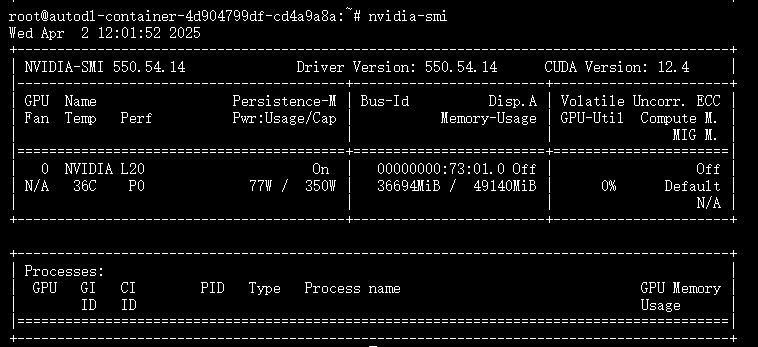

# 基于视频提问（二）

In [ ]:
#video_path = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen2.5-Omni/shopping.mp4"
video_path = "files/shopping.mp4"
prompt = "How many bottles of drinks have I picked up?"

display(Video(video_path, width=640, height=360))

## Use a local HuggingFace model to inference.
response = inference(video_path, prompt=prompt, sys_prompt="You are a helpful assistant.")
print(response[0])

system
You are a helpful assistant.
user
How many bottles of drinks have I picked up?
assistant
You have picked up two bottles of drinks.


# 基于视频提问（三）

In [ ]:
#video_path = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen2.5-Omni/shopping.mp4"
video_path = "files/shopping.mp4"
prompt = "How many milliliters are there in the bottle I picked up second time?"

display(Video(video_path, width=640, height=360))

## Use a local HuggingFace model to inference.
response = inference(video_path, prompt=prompt, sys_prompt="You are a helpful assistant.")
print(response[0])

system
You are a helpful assistant.
user
How many milliliters are there in the bottle I picked up second time?
assistant
The bottle you picked up second time contains 500 milliliters of liquid.
